# Hyperion Capstone 7

This project will focus on comparing the [K-mean](https://en.wikipedia.org/wiki/K-means_clustering) and the [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) methods of clustering data after applying Principle Componant Analysis. The dataset used in this notebook will be [US arrest statistics](https://www.kaggle.com/datasets/kurohana/usarrets). This dataset is described as; Arrests per 100,000 residents for assult, murder, and rape in each of the 50 US states in 1973.

The project strucutre:
- A small EDA on the dataset
- Applying PCA and tuning the number of principle componants
- Training a K-mean model
- Training a KNN model
- Comparing both models

In [49]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Loading and exploring data

In this section I will be looking at the data set and looking at the different attributes and how they link together. I will also be dealing with any empty values.

In [50]:
#Load data
df = pd.read_csv("UsArrests.csv")

#Checking for empty cells
df.info()

#Gets the first 5 rows
print("\n\nTop of the dataset:\n",df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Top of the dataset:
          City  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6


This initial opening of the dataset tells us that there are no empty cells that need to be dealt with. It also seems that the attribute names "City" is named wrong and should be "State" instead. The next step will be analysing the distribution of each statistic throughout the dataset.

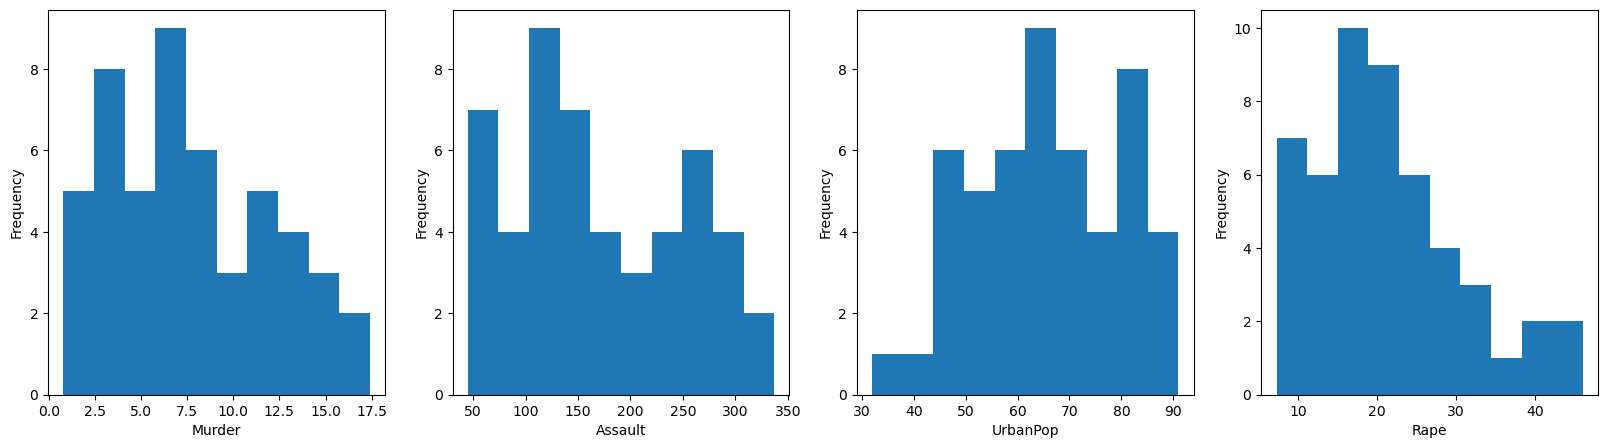

In [51]:
#Changes name of the "City" column
df.rename(columns={"City":"State"},inplace=True)

#Selects subset only containing numeric data
df_num = df.drop("State",axis=1).set_index(df.State.values)

#Generates subplots
fig,axs = plt.subplots(1,4,figsize=(20,5))

#Plots a histogram of each numeric column
for col,ax in zip(df_num,fig.axes):
    df[col].plot.hist(ax=ax)
    ax.set_xlabel(col)

**Murder per Capita**
- The most common rate of murder is around 2.5 and 7.5.
- Rates above 11 are much rarer.

**Assult per Capita**
- The rates have a similar shape to the murder rates, but the absolute values are much higher.
- Peak at 125, though there is another peak at 275.

**Urban Population**
- Most states have an urban population of around 65%.
- There seems to be a much more even spread of populations between 45% and 95% compared to the other statistic types.

**Rape per Capita**
- More rape occures in general than murders
- More assults then rapes
- There a rapid dropoff for rates above 25


The next step will be assessing if the dataset is a good fit for the application of PCA. A dataset that is a good candidate for PCA is one where there is strong positive or negative correlations between multiple columns. Meaning that linking these columns together could make the dataset easier to visualise (since there will be less than 4 columns), while not also losing a substantial amount of information.

[Text(0.5, 1.0, 'Correlation Grid')]

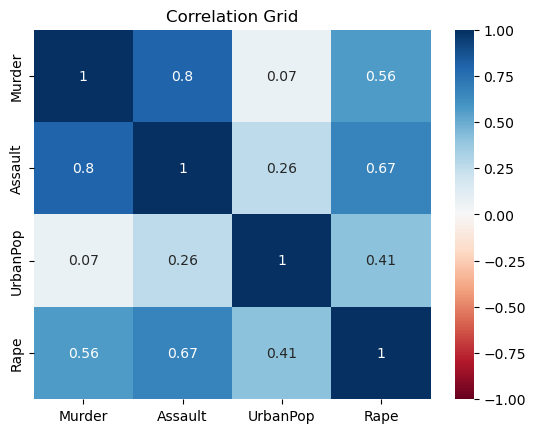

In [52]:
#Gets the correlation between each attribute with every other attribute
num_corr = df_num.corr()

#Plots correlation grid
sns.heatmap(num_corr,annot=True,vmin=-1,vmax=1,cmap="RdBu").set(title="Correlation Grid")

**Observations**
- None of the attributes shows a negative correlation.
- Most show a strong positive correlation.
- Murder rates and Urban population show the least correlation with a value of 0.07
- Assault rate and Urban population also shows a weak positive correlation
- Murder and assault rates have the highest correlation of 0.8

Overall, most of the attributes shows some sort of correlation with another. Therefore, doing a PCA would be beneficial and may result in data that could be visualised. However, shown in the histograms above, the range of values for each column is very different. For instance, the Urban population is given in percentage, while all other columns are per 100,000. Even within the columns that are per 100,000, there is a difference in their range. For example, murder rates reach a high of below 20, while assault rates reach a high of above 300.

This big difference in the columns will cause the PCA to favour the larger values which may skew the end result. For this reason, I will now normalise the data.

==================Unscaled data===================
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000

===================Scaled data====================
             Murder       Assault      UrbanPop          Rape
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01
mean  -7.105427e-17  1.387779e-16 -4.396483e-16  8.593126e-16
std    1.010153e+00  1.010153e+00  1.010153e+00  1.010153e+00
min   -1.620693e+00 -1.524362e+00 -2.340661e+00 -1.502548e+00
25%   -8.611383e-01 -7.486054e-01 -7.704502e-01 -6.640245e-01
50%   -1.247758e-01 -1.425453e-01  3.210209e-02 -1.220847e-01
75%    8.0292

Text(0.5, 1.0, 'Scaled Assault')

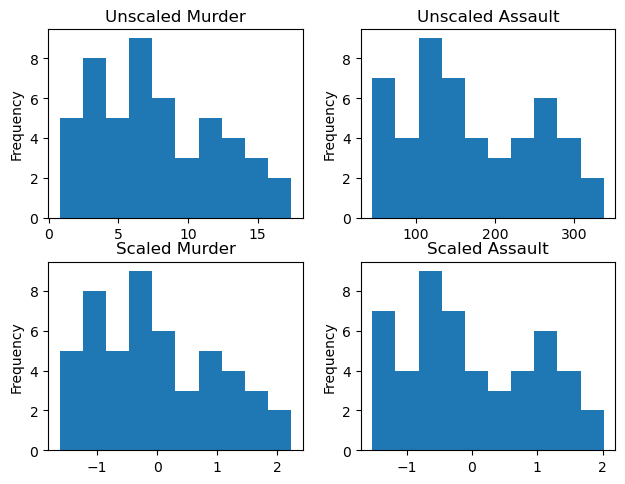

In [53]:
#Scale numric data and put into a new dataframe
df_num_scaled = pd.DataFrame(StandardScaler().fit_transform(df_num),columns=df_num.columns,index=df_num.index)

#Shows that the data has been scaled
print(f"{'Unscaled data':=^50}")
print(df_num.describe())
print(f"\n{'Scaled data':=^50}")
print(df_num_scaled.describe())

#Plots histogram of both datasets to verify scaling
fig,axs = plt.subplots(2,2)
fig.tight_layout()

#Murder plots
df_num.Murder.plot.hist(ax=axs[0,0])
axs[0,0].set_title("Unscaled Murder")
df_num_scaled.Murder.plot.hist(ax=axs[1,0])
axs[1,0].set_title("Scaled Murder")

#Assault plots
df_num.Assault.plot.hist(ax=axs[0,1])
axs[0,1].set_title("Unscaled Assault")
df_num_scaled.Assault.plot.hist(ax=axs[1,1])
axs[1,1].set_title("Scaled Assault")

After scaling the dataset, we can now see that all columns have a mean of 0, and a standard deviation of 1. This is futher shown in the histograms showing the unscaled and scaled data. Now both murder and assault have values that lie arounf -2 and 2, but the overall shape of the plots are conserved.

Before carrying out the PCA, a little more exploration can be done on the scaled dataset.

Murder:
Top: Georgia | Bottom: North Dakota

Assault:
Top: North Carolina | Bottom: North Dakota

UrbanPop:
Top: California | Bottom: Vermont

Rape:
Top: Nevada | Bottom: North Dakota



Text(212.59722222222223, 0.5, 'Bottom 5')

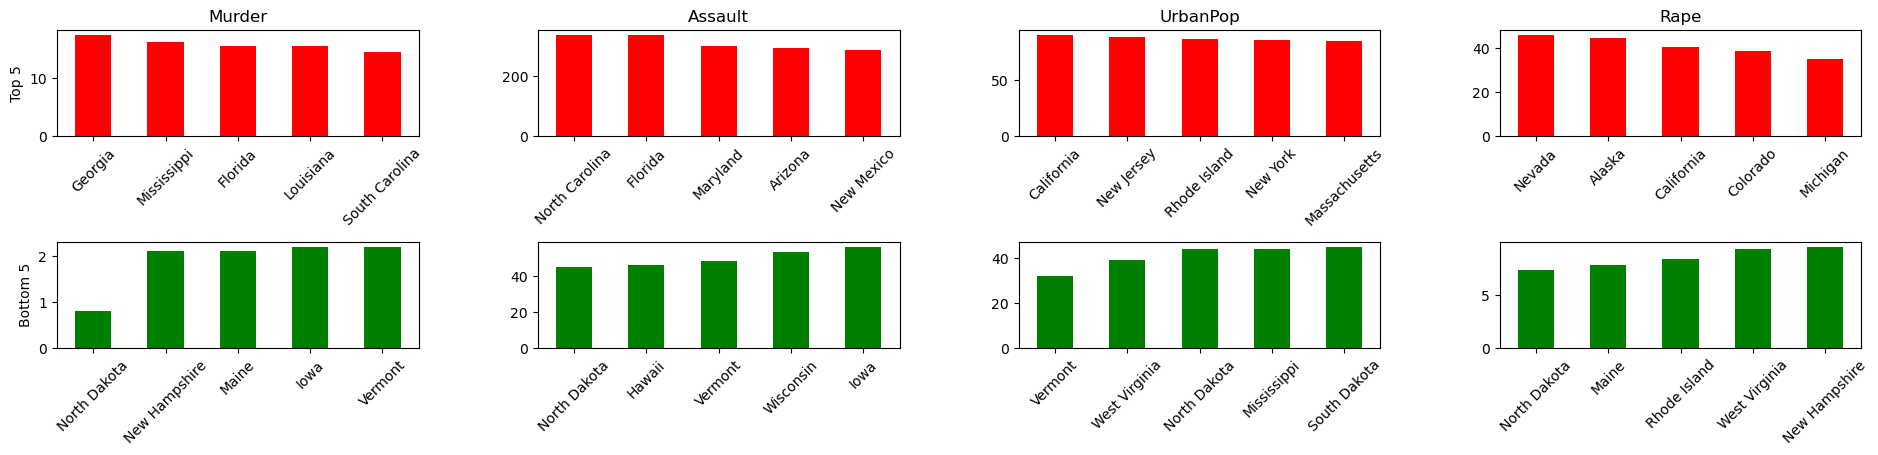

In [54]:
#Gets the state with the highest and lowest statistic for each column
for col in df_num:
    top = df_num[col].idxmax()
    bot = df_num[col].idxmin()
    print(f"{col}:")
    print(f"Top: {top} | Bottom: {bot}\n")

#Plots the top 5 states for each statistic
fig,axs = plt.subplots(2,4,figsize=(20,5))
fig.tight_layout(pad=5.5)
for i,col in enumerate(df_num):
    top_5 = df_num[col].sort_values(ascending=False).iloc[:5]
    top_5.plot.bar(ax=axs[0,i],color="r")
    axs[0,i].set_title(col)
    axs[0,i].tick_params(axis='x', labelrotation=45)

    bot_5 = df_num[col].sort_values(ascending=True).iloc[:5]
    bot_5.plot.bar(ax=axs[1,i],color="g")
    axs[1,i].tick_params(axis='x', labelrotation=45)

axs[0,0].set_ylabel("Top 5")
axs[1,0].set_ylabel("Bottom 5")


After looking at the extremes of the dataset, we can say that North Dakota is one of the safer states, while also being one with the lowest urban population. The same can be said for Vermont. Overall, a lot of the bottom 5 states in each statistic come up multiple times in other statistics.

On the other hand, this is not the case for the top 5. For instance, Florida only shows in in the Murder and Assault stats.

It is interesting to note that Mississippi has one of the highest murder rates, but also one of the lowest percentage of urban population.

## PCA

This section will be dedicated to the PCA of the data. A comparison to the scaled and unscaled data will be shown to demonstrate the importance of scaling the data. After that, the ratio of explained variance will be used to determine the optimal number of columns needed to reduce the complexity of the dataset, while also losing the least amount of information.

Once this analysis is done and the optimal number of columns if found, a clustering model will be applied to the data.

The first step is to apply the PCA to the datasets and visualise it. The visualisation will be done using a biplot. The biplot will show the position of the datapoints relative to some selected principle axes given by the PCA. It will also show the direction and importance of the original axes on relation to those axes.

In [55]:
def biplot(score,coeff,labels=None,points=None):
    """Plots a biplot that shows specific principle axes along with the datapoints"""

    #Gets data points from pca transformed data
    xs = score[:,0]
    ys = score[:,1]

    #Gets number of prinicple axes
    n = coeff.shape[0]

    #Scaled datapoints
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    #Plots the dataponits wrt principle axes
    ax.scatter(xs * scalex,ys * scaley,s=5)

    #Labels the datapoints
    for i in range(0,len(xs)):
        txt = points[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    #Draws oringinal axes wrt to new principle axes
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

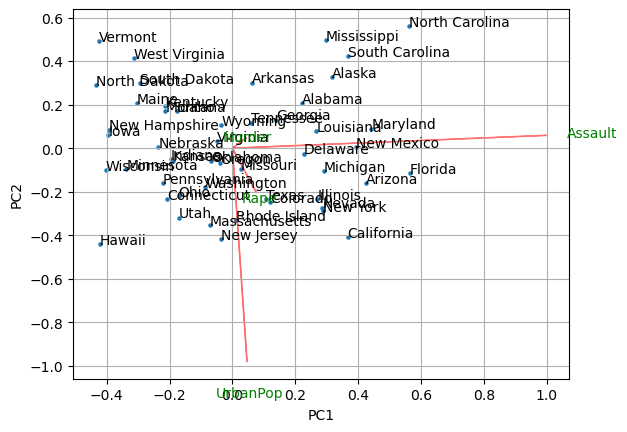

In [56]:
#Generates PCA object
r = 10
pca = PCA(random_state=r)

#Applies PCA to unscaled data
pca_unscaled_array = pca.fit_transform(df_num)
pca_unscaled = pd.DataFrame(pca_unscaled_array,index=df_num.index)

#Gets the principle axes components
unscaled_comps = pca.components_

#Plots biplot
biplot(pca_unscaled_array[:,0:2],np.transpose(unscaled_comps[0:2,:]),df_num.columns,df_num.index)


This biplot of the unscaled data shows that the Urban population and Assault columns dominate the principle axes, this is shown by the length of the red arrows. This makes sense since compared to the other columns, their range of values is much larger. We ideally want all the oringial axes to have a similar influence on the principle axes. This can be fixed by scaling the data. 

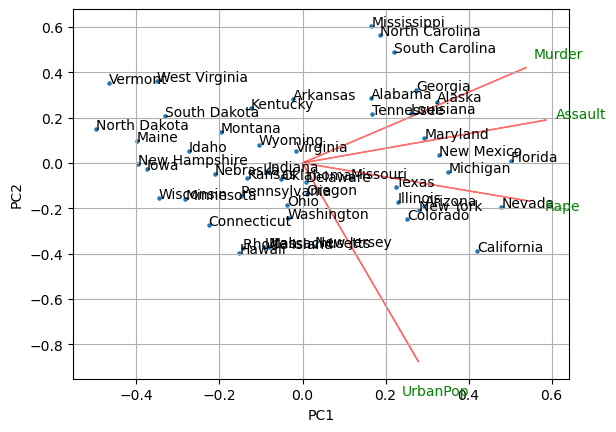

In [59]:
#Transforms scaled data via PCA
pca_scaled_array = pca.fit_transform(df_num_scaled)
pca_scaled = pd.DataFrame(pca_scaled_array,index=df_num_scaled.index)

#Gets principle axes components
scaled_comps = pca.components_

#Plots biplot
biplot(pca_scaled_array[:,0:2],np.transpose(scaled_comps[0:2,:]),df_num_scaled.columns,df_num_scaled.index)


Now that we have scaled the data, the biplot is much more even. Each of the original axes now have similar lengths and therefore similar importance levels.

The biplot indicates that the first principle axes (PC1) represents some sort of general danger level of a state, since all 3 columns that represent some crime are all points along the PC1 axes. The 2nd principle axes seems to represent the general population distribution of the state, having states with larger urban populations have negative PC2 values.

The next stage of the analysis to to determine the optimal number of columns. This is done by looking at how the explined variance changes depending on the number of principle axes used.

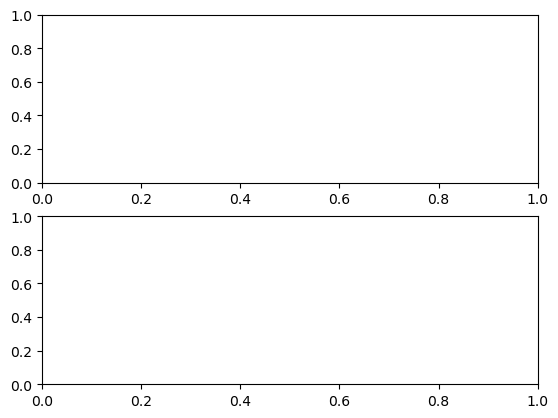

In [65]:
fig, axs = plt.subplots(2)

